<a href="https://colab.research.google.com/github/niteshpd/ml_projects/blob/master/Quora_Question_Pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connecting gDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# 1 Introduction and Data Description

The goal of this project is to predict which of the provided pairs of questions have the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

### Data Fields

* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
# Loading the required libraries

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from tqdm import tqdm

# Data Cleaning and preprocessing libraries
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler

# Modeling libraries
import random
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# loading the data from drive in pandas dataframe

train = pd.read_csv('/content/gdrive/My Drive/datasets/quora/train.csv')

# 2 Exploratory Data Analysis

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB




---


* Number of rows(Training question pairs) = 404290
* There are two NULL values in 'question2' column and one NULL value in 'question1' column.

---



0    255027
1    149263
Name: is_duplicate, dtype: int64


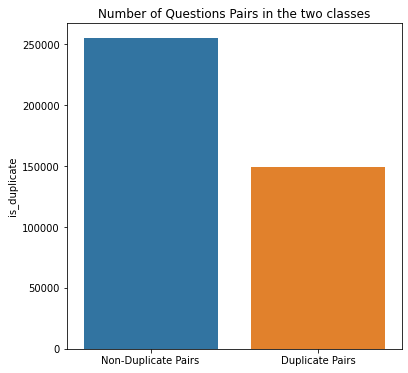

In [ ]:
# Distribution of the output classes

print(train['is_duplicate'].value_counts())
plt.figure(figsize=(6,6))
plt.title('Number of Questions Pairs in the two classes')
sns.barplot(['Non-Duplicate Pairs', 'Duplicate Pairs'], train['is_duplicate'].value_counts())
plt.show()

In [ ]:
# Number of unique questions in the entire dataset

ques = list(train['qid1']) + list(train['qid2'])
number_of_unique = len(np.unique(ques))
print('Number of Unique Questions = {} \nOut of total of {} questions'.format(number_of_unique, len(ques)))

Number of Unique Questions = 537933 
Out of total of 808580 questions


In [ ]:
# Number of questions appearing once and number of questions repeating

qid_frequency = pd.Series(ques).value_counts()

False    426153
True     382427
dtype: int64


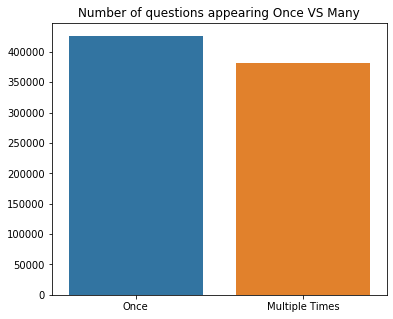

In [ ]:
# 'True' value which have duplicates and 'False' which appeared only once
count_many_once = pd.Series(ques).duplicated(keep=False).value_counts()
print(count_many_once)

plt.figure(figsize=(6,5))
plt.title('Number of questions appearing Once VS Many')
sns.barplot(['Once','Multiple Times'], count_many_once)
plt.show()

In [ ]:
# Duplicate Rows Check

duplicate_pairs = train[train.duplicated(subset=['qid1','qid2'])]
print('Number of duplicate question pairs =',len(duplicate_pairs))

Number of duplicate question pairs = 0


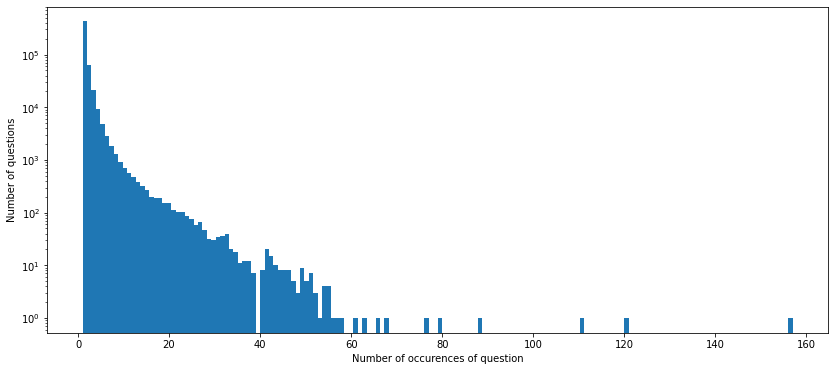

In [ ]:
# Histogram of Occurence of each question

plt.figure(figsize=(14,6))
plt.hist(qid_frequency, bins = 160)
plt.yscale('log')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

# 3 Data Cleaning(Text Preprocessing)
* HTML tags Removal
* Punctuation Removal
* Stemming
* Stopword Removal
* Conversion to lowecase
* Expanding Contractions

Ref : https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79

In [ ]:
# Spacy could be better used instead of nltk as it gives finer results


def _html_cleaner(sentence):
    # Ref: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', sentence).strip()


def _punc_cleaner(sentence):
    # Define puctuations wisely or it can be disastrous
    punctuations = '!?#$%^&*,:;-_(){}[]' # 14 Punctuations + more
    for character in sentence:
        if character in punctuations:
            sentence = sentence.replace(character, " ")
    return sentence.strip()


def _stemming(sentence):
    # This function also coverts and returns in lowercase
    words = sentence.split()
    snow = SnowballStemmer('english')
    stemmed = ''
    for word in words:
        stemmed = stemmed + snow.stem(word) + ' '
    return stemmed.strip()
    # Lemmatization can also be used instead


def _stop_removal(sentence):
    # Ref: https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/
    ''' This could be skipped as removing stopwords doesnot necessarily
    always improve accuracy. Read more to find when.'''

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = ''
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence = filtered_sentence + w + ' '
    return filtered_sentence.strip()


def _expand_contractions(sentence):
    # TBD
    pass


def _treat_numbers(sentence):
    # TBD
    pass


In [ ]:
# Calling the above functions


for i in tqdm(range(100000)):
    train['question1'][i] = _html_cleaner(train['question1'][i])
    train['question1'][i] = _punc_cleaner(train['question1'][i])
    train['question1'][i] = _stemming(train['question1'][i])
    train['question1'][i] = _stop_removal(train['question1'][i])
    train['question2'][i] = _html_cleaner(train['question2'][i])
    train['question2'][i] = _punc_cleaner(train['question2'][i])
    train['question2'][i] = _stemming(train['question2'][i])
    train['question2'][i] = _stop_removal(train['question2'][i])

  0%|          | 0/100000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_la

In [ ]:
train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
# Better to perform this before preprocessing but remove stopwords

def _plot_wcloud(text):
    # Ref: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
    wc = WordCloud(width = 500, height = 200)
    wc.generate(text)
    # Set figure size
    # plt.figure(figsize=(50,50))
    # Display Image
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

In [ ]:
dup_ques = ''
nondup_ques = ''
for i in tqdm(range(100000)):
    if train['is_duplicate'][i] == 0:
        for word in word_tokenize(train['question1'][i]):
            nondup_ques = nondup_ques + word + ' '
        for word in word_tokenize(train['question2'][i]):
            nondup_ques = nondup_ques + word + ' '
    else:
        for word in word_tokenize(train['question1'][i]):
            dup_ques = dup_ques + word + ' '
        for word in word_tokenize(train['question2'][i]):
            dup_ques = dup_ques + word + ' '

100%|██████████| 100000/100000 [16:55<00:00, 98.43it/s]


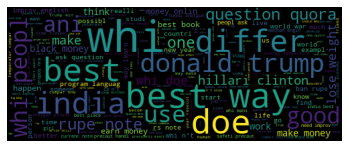

In [ ]:
_plot_wcloud(dup_ques)

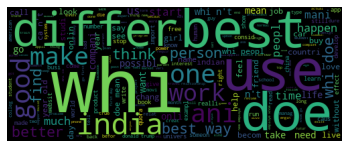

In [ ]:
_plot_wcloud(nondup_ques)

# 4 Featurization

In [ ]:
# Download Glove file
# Also try GloVe Common Crawl
# Here we will be using Google News Word2Vec Model

# !wget 

In [ ]:
# Extract the downloaded file from gdrive

!gunzip /content/gdrive/My\ Drive/datasets/google_news_vectors.bin.gz

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

w2v_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/datasets/google_news_vectors.bin', binary = True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Building Avg Word2Vec of our Questions

def avg_w2vec(sentence):
    split_words = sentence.split()
    c = 0
    vector = np.zeros((1,300))
    for word in split_words:
        if word in w2v_model.vocab:
            vector += w2v_model[word].reshape(1,300)
            c = c + 1
    if c is not 0:
        return vector/c
    else:
        return np.zeros([1,300])

In [ ]:
num_data_points = 100000
questions_avg_w2v = np.zeros([num_data_points,600])

In [ ]:
for i in tqdm(range(num_data_points)):
    questions_avg_w2v[i] = np.concatenate((avg_w2vec(train['question1'][i]), avg_w2vec(train['question2'][i])), axis=1)

100%|██████████| 100000/100000 [00:13<00:00, 7206.91it/s]


In [ ]:
questions_avg_w2v.shape

(100000, 600)

In [ ]:
# Saving the average Word2Vec array to numpy file

np.save('/content/gdrive/My Drive/datasets/quora/featurized_input.npy', questions_avg_w2v)

In [3]:
# Loading the saved file from drive

questions_avg_w2v = np.load('/content/gdrive/My Drive/datasets/quora/featurized_input.npy')

In [6]:
# Storing labels in a separate variable

y_true = train['is_duplicate'][0:100000]

# 5 Model Exploration

In [7]:
# Data Splitting

X_train, X_cv, y_train, y_cv = train_test_split(questions_avg_w2v[0:20000], y_true[0:20000], test_size=0.3)

In [16]:
# Confusion Matrix Heatmap function definition
# Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

def _confusion_matrix_heatmap(y_tru, y_predicted):
    cf_matrix = confusion_matrix(y_tru, y_predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## 5.1 Random Model

In [ ]:
# This is to define the upper bound of log loss of our models.

y_pred = np.random.rand(100000)

log_loss(y_true, y_pred)

0.9987112719829875



---


This is the upper bound of our log loss and all the subsequent explored models should have loss less than it.

---



In [ ]:
test_len = 100000
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    i
print("Log loss on Test Data using Random Model",log_loss(y_true, predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 0.8852880581260805




---


This is strange. Single column method gives us logloss of ~1 while double column method gives better log loss with ~0.88.

---



In [ ]:
t_trans = predicted_y.transpose()

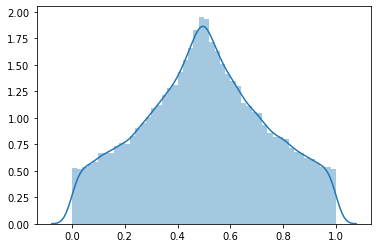

In [ ]:
sns.distplot(t_trans[0])

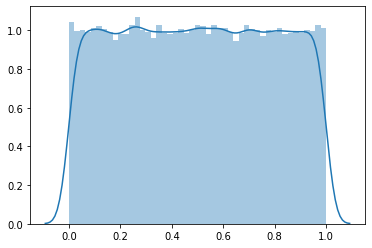

In [ ]:
sns.distplot(y_pred)

---
The difference in logloss of the two methods is due to different distribution of data points. Normalizing the two columns to add to 1 made the uniformly distributed data to normally distributed with mean 0.5 as evident by above distribution plots.


---



## 5.2 Logistic Regression

In [ ]:
# Also try by making pipeline and StandardScalar to scale the inputs

alpha = [10 ** i for i in range(-6,1)]
log_loss_array = []
print('Results on CV set:\n')
for j in alpha:
    clf = SGDClassifier(loss='log', penalty='l2', alpha=j, fit_intercept=True, n_jobs=-1)
    clf.fit(X_train, y_train)
    cal_clf = CalibratedClassifierCV(clf, method='sigmoid') # Why Calibrated Classifier?
    cal_clf.fit(X_train, y_train)
    y_cv_proba = cal_clf.predict_proba(X_cv)
    y_cv_pred = clf.predict(X_cv)
    temp_loss = log_loss(y_cv, y_cv_proba)
    log_loss_array.append(temp_loss)
    print("For alpha = {}, logloss = {}".format(j, round(temp_loss, 4)))



Results on CV set:

For alpha = 1e-06, logloss = 0.6406
For alpha = 1e-05, logloss = 0.6325
For alpha = 0.0001, logloss = 0.6293
For alpha = 0.001, logloss = 0.6261
For alpha = 0.01, logloss = 0.632
For alpha = 0.1, logloss = 0.6404
For alpha = 1, logloss = 0.6459


---

We observe that the above model works best for alpha = 0.0001. So we proceed further using this value to investigate further metrics like Precision, Recall and F1-Score.

---

In [ ]:
alpha_opt_idx = np.argmin(log_loss_array)       # Optimal alpha
loss_opt_idx = log_loss_array[alpha_opt_idx]    # Optimal loss

clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[alpha_opt_idx], fit_intercept=True, n_jobs=-1)
clf.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(clf, method='sigmoid')
cal_clf.fit(X_train, y_train)

y_cv_proba = cal_clf.predict_proba(X_cv)
y_train_proba = cal_clf.predict_proba(X_train)

print('Train log loss for optimal alpha = ',round(log_loss(y_train, y_train_proba), 4))
print('CV log loss optimal alpha = ',round(log_loss(y_cv, y_cv_proba), 4))

Train log loss for optimal alpha =  0.5999
CV log loss optimal alpha =  0.626


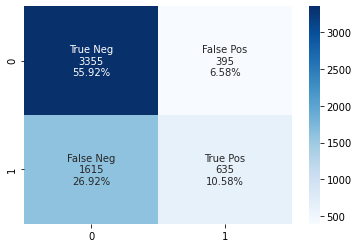

In [ ]:
_confusion_matrix_heatmap(y_cv, cal_clf.predict(X_cv))

## 5.3 GBDT and XGBoost

In [ ]:
depth = 20
while depth < 100:
    clf_gbdt = GradientBoostingClassifier(n_estimators=10,max_depth=depth, verbose=1)
    clf_gbdt.fit(X_train, y_train)
    print(log_loss(y_cv, clf_gbdt.predict_proba(X_cv)))
    depth += 10

In [13]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_cv = xgb.DMatrix(X_cv, label=y_cv)

watchlist = [(d_train, 'train'), (d_cv, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=5, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_cv)


[0]	train-logloss:0.690701	valid-logloss:0.691026
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[10]	train-logloss:0.670336	valid-logloss:0.673632
[20]	train-logloss:0.654744	valid-logloss:0.660498
[30]	train-logloss:0.642213	valid-logloss:0.650349
[40]	train-logloss:0.631751	valid-logloss:0.642273
[50]	train-logloss:0.622955	valid-logloss:0.635785
[60]	train-logloss:0.614827	valid-logloss:0.630128
[70]	train-logloss:0.607764	valid-logloss:0.625155
[80]	train-logloss:0.601004	valid-logloss:0.620691
[90]	train-logloss:0.594948	valid-logloss:0.616815
[100]	train-logloss:0.58917	valid-logloss:0.613166
[110]	train-logloss:0.583914	valid-logloss:0.610056
[120]	train-logloss:0.578776	valid-logloss:0.607014
[130]	train-logloss:0.574108	valid-logloss:0.604402
[140]	train-logloss:0.5698	valid-logloss:0.60203
[150]	train-logloss:0.565689	valid-logloss:0.599951
[160]	train-logloss:0.561828	vali

NameError: ignored

In [15]:
print("The test log loss is:",log_loss(y_cv, predict_y))

The test log loss is: 0.5678603621795774


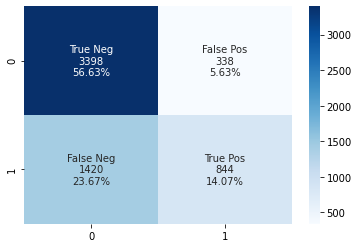

In [19]:
_confusion_matrix_heatmap(y_cv, n(predict_y>0.5))